In [1]:
!pip install matplotlib
!pip install optimum
!pip install onnxruntime
!pip install onnx
!pip install cupy


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached cupy-13.3.0.tar.gz (3.4 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      Generating cache key from header files...
      Cache key (1610 files matching /private/var/folders/l1/xn4zqt856pd5q_jbvzm1xkz00000gn/T/pip-install-0h1r_rvz/cupy_5cc31775d3dc4c59a4092f7c7a596aa5/cupy/_core/include/**): 212566004acb2d0c63365be5b9ad9dfd9389ec88
      Error: macOS is no longer supported
      [end of ou

In [101]:
import pandas as pd
import torch
import time
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from optimum.onnxruntime import (
    AutoQuantizationConfig,
    ORTModelForSequenceClassification,
    ORTQuantizer
)
from optimum.pipelines import pipeline
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a Dummy DataFrame for Fine-tuning
data = {
    "text": [
        "I bought a new laptop",
        "The product is great",
        "I want to return this item",
        "Amazing customer service",
        "I had a terrible experience",
        "Great product but expensive",
        "Worst purchase ever"
    ],
    "label": [1, 0, 1, 0, 1, 0, 1]  # 1: Purchase-related, 0: Non-purchase-related
}

df = pd.DataFrame(data)

In [102]:
import torch

In [103]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import time

# Train-test split
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()


# Load tokenizer and pre-trained model:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenizar el texto
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Convert the DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)

# Training arguments:
training_args = TrainingArguments(
    output_dir='./results',          # Directorio de salida
    num_train_epochs=1,              # Número de épocas
    per_device_train_batch_size=16,   # Tamaño del batch por dispositivo
    logging_dir='./logs',            # Directorio de logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # El modelo a fine-tunear
    args=training_args,                  # Argumentos de entrenamiento
    train_dataset=train_dataset,         # Dataset de entrenamiento
)

# Measure training time:
start_time = time.time()

# Fine-tunning model:
trainer.train()

end_time = time.time()

# Save training time:
training_time = end_time - start_time

print(f"Tiempo de fine-tuning: {training_time:.2f} segundos")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1/1 [00:05<00:00,  5.57s/it]

{'train_runtime': 5.5718, 'train_samples_per_second': 0.897, 'train_steps_per_second': 0.179, 'train_loss': 0.709450900554657, 'epoch': 1.0}
Tiempo de fine-tuning: 6.41 segundos


In [104]:
# Save the fine-tuned model
fine_tuned_model_dir = "./distilbert_finetuned"
model.save_pretrained(fine_tuned_model_dir)
tokenizer.save_pretrained(fine_tuned_model_dir)

('./distilbert_finetuned/tokenizer_config.json',
 './distilbert_finetuned/special_tokens_map.json',
 './distilbert_finetuned/vocab.txt',
 './distilbert_finetuned/added_tokens.json')

In [105]:
# Step 3: Export the fine-tuned model to ONNX
onnx_save_dir = "distilbert_finetuned_onnx"
ort_model = ORTModelForSequenceClassification.from_pretrained(fine_tuned_model_dir, export=True)

# Save the ONNX model
ort_model.save_pretrained(onnx_save_dir)

In [106]:
# Step 4: Quantize the model
from optimum.onnxruntime import AutoQuantizationConfig, ORTQuantizer

# Load the fine-tuned ONNX model
qconfig = AutoQuantizationConfig.avx512_vnni(is_static=False, per_channel=True)
quantizer = ORTQuantizer.from_pretrained(onnx_save_dir)

# Quantize the model
quantizer.quantize(save_dir="distilbert_finetuned_quantized", quantization_config=qconfig)

# Load the quantized model
quantized_model = ORTModelForSequenceClassification.from_pretrained("distilbert_finetuned_quantized")

Fine-tuned model inference time: 0.0093 seconds
ONNX model inference time: 0.0080 seconds
Quantized model inference time: 0.0049 seconds


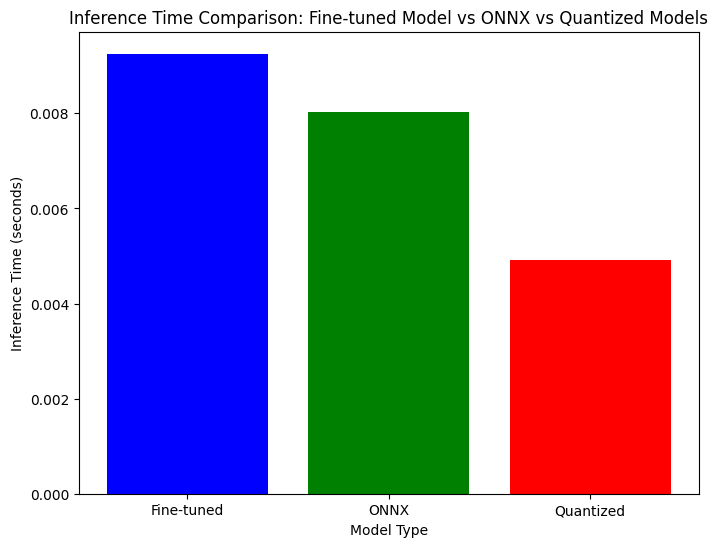

In [107]:
# Step 5: Measure Inference Time for Fine-tuned Model
finetuned_model = pipeline("text-classification", model=fine_tuned_model_dir)
start_time = time.time()
pred_finetuned = finetuned_model("I bought a new laptop")
finetuned_inference_time = time.time() - start_time
print(f"Fine-tuned model inference time: {finetuned_inference_time:.4f} seconds")

# Step 6: Measure Inference Time for ONNX Model
onnx_clx = pipeline("text-classification", model=onnx_save_dir, accelerator="ort")
start_time = time.time()
pred_onnx = onnx_clx("I bought a new laptop")
onnx_inference_time = time.time() - start_time
print(f"ONNX model inference time: {onnx_inference_time:.4f} seconds")

# Step 7: Measure Inference Time for Quantized Model
onnx_clx_quantized = pipeline("text-classification", model=quantized_model, accelerator="ort")
start_time = time.time()
pred_quantized = onnx_clx_quantized("I bought a new laptop")
quantized_inference_time = time.time() - start_time
print(f"Quantized model inference time: {quantized_inference_time:.4f} seconds")

# Step 8: Compare and Graph Inference Times
models = ['Fine-tuned', 'ONNX', 'Quantized']
inference_times = [finetuned_inference_time, onnx_inference_time, quantized_inference_time]

plt.figure(figsize=(8, 6))
plt.bar(models, inference_times, color=['blue', 'green', 'red'])
plt.xlabel('Model Type')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Fine-tuned Model vs ONNX vs Quantized Models')
plt.show()

# Apply the model over 100 descriptions to have more exactitude with inference time:

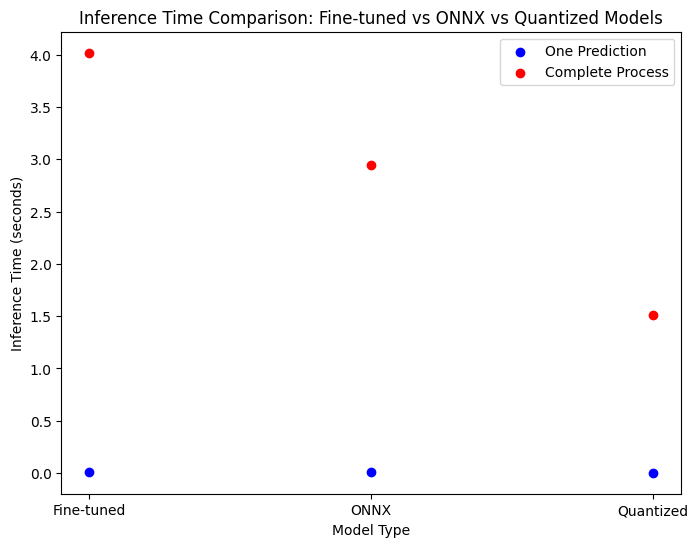

Fine-tuned model CPU usage: 64.50%
ONNX model CPU usage: 55.70%
Quantized model CPU usage: 55.90%


In [95]:
import time
import psutil
import matplotlib.pyplot as plt
from transformers import pipeline
import numpy as np

# Step 1: Define the list of 100 different descriptions for testing
descriptions = [
    "I bought a new laptop", "The car needs repairs", "She sold her old phone", "He purchased a new TV",
    "They are selling their house", "I sold my old bicycle", "Bought groceries today", "She bought a new dress",
    "I got a new job", "He invested in stocks", "She bought a new book", "They rented an apartment",
    "I purchased a gaming console", "He sold his camera", "She upgraded her phone", "They bought a dog",
    "I got a promotion at work", "He purchased a plane ticket", "She bought a new sofa", "They sold their old car",
    "I bought a smartwatch", "He is buying a new house", "She sold her jewelry", "They invested in real estate",
    "I got a new pair of shoes", "He bought a gym membership", "She purchased a bike", "They sold their furniture",
    "I invested in cryptocurrency", "He bought a new smartphone", "She sold her paintings", "They are buying a yacht",
    "I bought concert tickets", "He purchased a gaming chair", "She sold her old furniture", "They bought a new fridge",
    "I got a new tablet", "He sold his old laptop", "She bought a fancy watch", "They purchased a vacation package",
    "I sold my old car", "He bought a car insurance plan", "She got a new haircut", "They bought new curtains",
    "I purchased a pair of sunglasses", "He is selling his artwork", "She bought a coffee maker", "They sold their antique clock",
    "I invested in mutual funds", "He purchased a camping tent"
]

# Step 2: Measure CPU usage and inference time for Fine-tuned Model, ONNX Model, and Quantized Model
def measure_inference_time_and_cpu(model, text_list):
    cpu_before = psutil.cpu_percent()
    start_time = time.time()
    predictions = [model(text) for text in text_list]
    inference_time = time.time() - start_time
    cpu_after = psutil.cpu_percent()
    cpu_usage = cpu_after - cpu_before
    return inference_time, cpu_usage, predictions


# Measure inference time and CPU usage for Fine-tuned model
finetuned_inference_time, finetuned_cpu_usage, predictions_finetuned_model = measure_inference_time_and_cpu(finetuned_model, descriptions)

# Measure inference time and CPU usage for ONNX model
onnx_inference_time, onnx_cpu_usage, predictions_onnx_clx = measure_inference_time_and_cpu(onnx_clx, descriptions)

# Measure inference time and CPU usage for Quantized model
quantized_inference_time, quantized_cpu_usage, predictions_onnx_clx_quantized = measure_inference_time_and_cpu(onnx_clx_quantized, descriptions)

# Step 4: Create Scatter Plot Comparing Time for One Prediction and Complete Process
labels = ['Fine-tuned', 'ONNX', 'Quantized']
times_for_one = [finetuned_inference_time / len(descriptions), onnx_inference_time / len(descriptions), quantized_inference_time / len(descriptions)]
times_for_all = [finetuned_inference_time, onnx_inference_time, quantized_inference_time]

# Create a scatter plot for comparison
plt.figure(figsize=(8, 6))
plt.scatter(labels, times_for_one, color='blue', label='One Prediction')
plt.scatter(labels, times_for_all, color='red', label='Complete Process')

plt.xlabel('Model Type')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Fine-tuned vs ONNX vs Quantized Models')
plt.legend()
plt.show()

# Step 5: Output CPU Usage
print(f"Fine-tuned model CPU usage: {finetuned_cpu_usage:.2f}%")
print(f"ONNX model CPU usage: {onnx_cpu_usage:.2f}%")
print(f"Quantized model CPU usage: {quantized_cpu_usage:.2f}%")


In [108]:
len(descriptions)

500

In [14]:
import time
import psutil
import torch
from transformers import pipeline
import matplotlib.pyplot as plt

# Function to get GPU usage (if available)
def get_gpu_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated(), torch.cuda.memory_cached()
    else:
        return None, None

# Function to measure CPU usage
def get_cpu_usage():
    return psutil.cpu_percent()

# List of descriptions (you can modify this list to match your dataset)
descriptions = [
    "I bought a new laptop", "The car needs repairs", "She sold her old phone", "He purchased a new TV",
    "They are selling their house", "I sold my old bicycle", "Bought groceries today", "She bought a new dress",
    "I got a new job", "He invested in stocks", "She bought a new book", "They rented an apartment",
    "I purchased a gaming console", "He sold his camera", "She upgraded her phone", "They bought a dog",
    "I got a promotion at work", "He purchased a plane ticket", "She bought a new sofa", "They sold their old car",
    "I bought a smartwatch", "He is buying a new house", "She sold her jewelry", "They invested in real estate",
    "I got a new pair of shoes", "He bought a gym membership", "She purchased a bike", "They sold their furniture",
    "I invested in cryptocurrency", "He bought a new smartphone", "She sold her paintings", "They are buying a yacht",
    "I bought concert tickets", "He purchased a gaming chair", "She sold her old furniture", "They bought a new fridge",
    "I got a new tablet", "He sold his old laptop", "She bought a fancy watch", "They purchased a vacation package",
    "I sold my old car", "He bought a car insurance plan", "She got a new haircut", "They bought new curtains",
    "I purchased a pair of sunglasses", "He is selling his artwork", "She bought a coffee maker", "They sold their antique clock",
    "I invested in mutual funds", "He purchased a camping tent"
]

# Function to make prediction and print GPU usage for each model
def make_prediction(model, description):
    
    # Start time for inference
    start_time = time.time()
    
    # Make prediction
    prediction = model(description)
    
    # Calculate inference time
    inference_time = time.time() - start_time
    
    return prediction, inference_time

# Step 2: Run predictions for each model and each description
finetuned_inference_times = []
onnx_inference_times = []
quantized_inference_times = []

predictions_finetuned = []
predictions_usage_onnx = []
predictions_quantized = []

In [42]:
def model_predict(model, list_descriptions: list):
    
    list_prediction = []
    list_inference_time = []
    
    for desc in list_descriptions:
        prediction, inference_time = make_prediction(model, desc)
        list_prediction.append(prediction)
        list_inference_time.append(inference_time)
    
    list_prediction_clean = [item[0] for item in list_prediction]
        
    return list_prediction_clean, list_inference_time

In [44]:
list_finetuned_model, list_inference_finetuned_model = model_predict(finetuned_model, descriptions)
list_onnx_clx, list_inference_onnx_clx = model_predict(onnx_clx, descriptions)
list_onnx_clx_quantized, list_inference_onnx_clx_quantized = model_predict(onnx_clx_quantized, descriptions)


In [72]:
df_predicted_fine_tunned_model = pd.DataFrame(list_finetuned_model)
df_predicted_onnx_clx = pd.DataFrame(list_onnx_clx)
df_predicted_onnx_clx_quantized = pd.DataFrame(list_onnx_clx_quantized)

label_fine_tunned_model = df_predicted_fine_tunned_model['label']
label_onnx_clx = df_predicted_onnx_clx['label']
label_onnx_clx_quantized = df_predicted_onnx_clx_quantized['label']

In [76]:
df_predicted = pd.DataFrame({'label_fine_tunned_model':label_fine_tunned_model
                             ,'label_onnx_clx': label_onnx_clx
                             ,'label_onnx_clx_quantized': label_onnx_clx_quantized
                             ,'description': descriptions}
                            , columns = ['description','label_fine_tunned_model','label_onnx_clx','label_onnx_clx_quantized', ])

In [80]:
df_predicted['SAME_LABEL'] = (df_predicted['label_fine_tunned_model']==df_predicted['label_onnx_clx'])&(df_predicted['label_onnx_clx']==df_predicted['label_onnx_clx_quantized'])

In [82]:
df_predicted['SAME_LABEL'].value_counts(normalize=True)

SAME_LABEL
True     0.86
False    0.14
Name: proportion, dtype: float64

In [83]:
df_predicted[df_predicted['SAME_LABEL']==False]

,description,label_fine_tunned_model,label_onnx_clx,label_onnx_clx_quantized,SAME_LABEL
10,She bought a new book,LABEL_0,LABEL_0,LABEL_1,False
13,He sold his camera,LABEL_1,LABEL_1,LABEL_0,False
19,They sold their old car,LABEL_1,LABEL_1,LABEL_0,False
23,They invested in real estate,LABEL_0,LABEL_0,LABEL_1,False
30,She sold her paintings,LABEL_0,LABEL_0,LABEL_1,False
34,She sold her old furniture,LABEL_1,LABEL_1,LABEL_0,False
43,They bought new curtains,LABEL_0,LABEL_0,LABEL_1,False


In [114]:
df_predicted['label_fine_tunned_model'].value_counts(normalize=True)

label_fine_tunned_model
LABEL_1    0.72
LABEL_0    0.28
Name: proportion, dtype: float64

In [115]:
df_predicted['label_onnx_clx'].value_counts(normalize=True)

label_onnx_clx
LABEL_1    0.72
LABEL_0    0.28
Name: proportion, dtype: float64

In [116]:
df_predicted['label_onnx_clx_quantized'].value_counts(normalize=True)

label_onnx_clx_quantized
LABEL_1    0.74
LABEL_0    0.26
Name: proportion, dtype: float64

# Al aplicar quantización al modelo, cambiaron el 14% de las categorías que el modelo predijo.

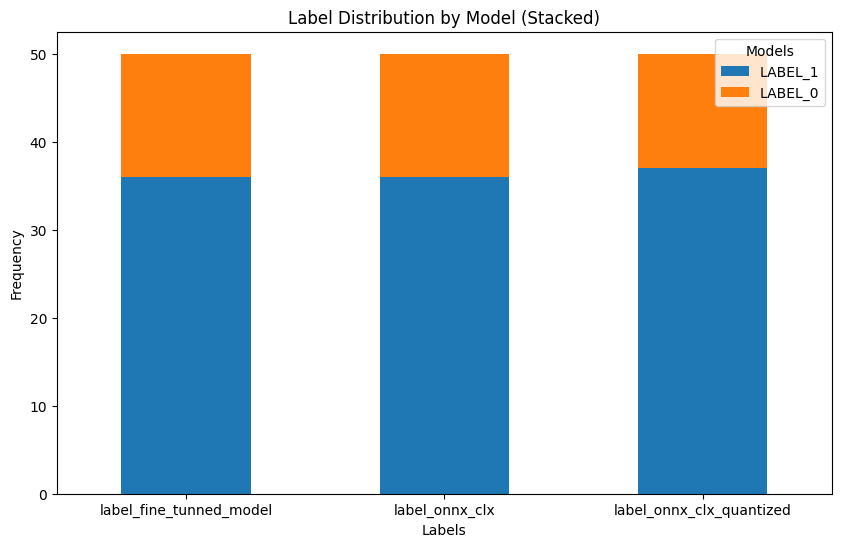

In [113]:
# Specify the columns to analyze
columns_to_analyze = ["label_fine_tunned_model", "label_onnx_clx", "label_onnx_clx_quantized"]

# Count the label distribution for each model
label_counts = {col: df_predicted[col].value_counts() for col in columns_to_analyze}

# Convert to a single DataFrame for easier plotting
distribution_df = pd.DataFrame(label_counts).fillna(0)
distribution_df = distribution_df.T

# Plot a stacked bar chart
distribution_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Add labels and title
plt.title("Label Distribution by Model (Stacked)")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.legend(title="Models")
plt.xticks(rotation=0)
plt.show()

In [112]:
distribution_df

,label_fine_tunned_model,label_onnx_clx,label_onnx_clx_quantized
LABEL_1,36,36,37
LABEL_0,14,14,13
